In [3]:
import numpy as np
import albumentations as A
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as TF
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
# from google.colab import  drive
import shutil
import os



In [2]:
!pip install torchsummary

In [21]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/kaggle/working/train/images"
TRAIN_MASK_DIR = "/kaggle/working/train/masks"
VALID_IMG_DIR = "/kaggle/working/validations/images"
VALID_MASK_DIR = "/kaggle/working/validations/masks"


In [ ]:

# drive.mount('/content/drive')


In [5]:
!unzip "/kaggle/input/carvana-image-masking-challenge/train_masks.zip" -d "train_masks"

Archive:  /kaggle/input/carvana-image-masking-challenge/train_masks.zip
   creating: train_masks/train_masks/
  inflating: train_masks/train_masks/00087a6bd4dc_01_mask.gif  
 extracting: train_masks/train_masks/00087a6bd4dc_02_mask.gif  
 extracting: train_masks/train_masks/00087a6bd4dc_03_mask.gif  
 extracting: train_masks/train_masks/00087a6bd4dc_04_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_05_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_06_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_07_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_08_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_09_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_10_mask.gif  
 extracting: train_masks/train_masks/00087a6bd4dc_11_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_12_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_13_mask.gif  
  inflating: train_masks/train_masks/00087a6bd4dc_14_mask.

In [ ]:
len(os.listdir("/kaggle/input/carvana-image-masking-png/train_images"))

## utils

In [6]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


## dataset

In [ ]:
# os.listdir("/kaggle/input/carvana-image-masking-png/train_images")

In [7]:
class Carvana(Dataset):
  def __init__(self,image_dir,mask_dir,transforms=None):
    super().__init__()
    self.image_dir=image_dir
    self.mask_dir=mask_dir
    self.transforms=transforms
    self.image_list=os.listdir(self.image_dir)
  def __len__(self):
    return len(self.image_list)
  def __getitem__(self, index) :
    image_path=os.path.join(self.image_dir,self.image_list[index])
    mask_path=os.path.join(self.mask_dir,self.image_list[index].replace(".jpg","_mask.gif"))
    image=np.array(Image.open(image_path).convert("RGB"))
    mask=np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
    mask[mask==255]=1
    if self.transforms is not None :
      augmantation=self.transforms(image=image,mask=mask)
      image=augmantation["image"]
      mask=augmantation["mask"]
    return image,mask


In [8]:
data=Carvana("/kaggle/input/carvana-image-masking-png/train_images","/kaggle/working/train_masks/train_masks")
image,mask=data[2]

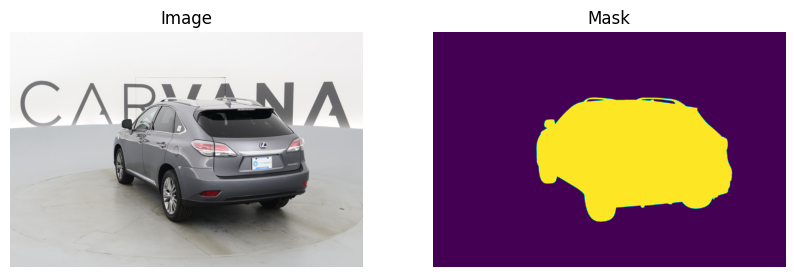

In [9]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis("off")
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis("off")
plt.title("Mask")
plt.show()

In [10]:
file=os.listdir("/kaggle/input/carvana-image-masking-png/train_images")
if not os.path.isdir("/kaggle/working/validation"):
    os.makedirs("/kaggle/working/validations/images")
    os.makedirs("/kaggle/working/validations/masks")
    for i in tqdm(range(500)):
        image_path=os.path.join("/kaggle/input/carvana-image-masking-png/train_images",file[i])
        mask_path=os.path.join("/kaggle/working/train_masks/train_masks",file[i].replace(".jpg","_mask.gif"))
        shutil.copy(image_path,"/kaggle/working/validations/images")
        shutil.move(mask_path,"/kaggle/working/validations/masks")
mask_file=os.listdir("/kaggle/working/train_masks/train_masks")

if not os.path.isdir("/kaggle/working/train"):
    os.makedirs("/kaggle/working/train/images")
    os.makedirs("/kaggle/working/train/masks")
    for i in tqdm(range(len(mask_file)) ):
        mask_path=os.path.join("/kaggle/working/train_masks/train_masks",mask_file[i])
        image_path=os.path.join("/kaggle/input/carvana-image-masking-png/train_images",mask_file[i].replace("_mask.gif",".jpg"))
        
        shutil.copy(image_path,"/kaggle/working/train/images")
        shutil.move(mask_path,"/kaggle/working/train/masks")
              
        
   

100%|██████████| 4588/4588 [00:59<00:00, 77.10it/s]


## model

In [11]:
class DoubleConv(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channel,out_channel,3,1,1,bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel,out_channel,3,1,1,bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.conv(x)

In [12]:
class Unet(nn.Module):
  def __init__(self,in_channel=3,out_channel=1,features=[64,128,256,512]):
    super().__init__()
    self.ups=nn.ModuleList()
    self.down=nn.ModuleList()

    for feature in features:
      self.down.append(DoubleConv(in_channel,feature))
      in_channel=feature
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
      self.ups.append(DoubleConv(feature*2,feature))
    self.bottelneck=DoubleConv(features[-1],features[-1]*2)
    self.out=nn.Conv2d(features[0],out_channel,kernel_size=1)
  def forward(self,x):
    skip_connections=[]
    for l in self.down:
      x=l(x)
      skip_connections.append(x)
      x=self.pool(x)
    x=self.bottelneck(x)
    skip_connections=skip_connections[::-1]
    for idx in range(0,len(self.ups),2):
      x=self.ups[idx](x)
      skip_connection=skip_connections[idx//2]
      # print(skip_connection.shape,x.shape)
      if x.shape!= skip_connection.shape:
        x=TF.resize(x,size=skip_connection.shape[2:])
      concat_out=torch.cat([skip_connection,x],dim=1)
      x=self.ups[idx+1](concat_out)
    return self.out(x)






In [13]:
model=Unet().to(DEVICE)
summary(model, (3, 572, 572))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]           1,728
       BatchNorm2d-2         [-1, 64, 572, 572]             128
              ReLU-3         [-1, 64, 572, 572]               0
            Conv2d-4         [-1, 64, 572, 572]          36,864
       BatchNorm2d-5         [-1, 64, 572, 572]             128
              ReLU-6         [-1, 64, 572, 572]               0
        DoubleConv-7         [-1, 64, 572, 572]               0
         MaxPool2d-8         [-1, 64, 286, 286]               0
            Conv2d-9        [-1, 128, 286, 286]          73,728
      BatchNorm2d-10        [-1, 128, 286, 286]             256
             ReLU-11        [-1, 128, 286, 286]               0
           Conv2d-12        [-1, 128, 286, 286]         147,456
      BatchNorm2d-13        [-1, 128, 286, 286]             256
             ReLU-14        [-1, 128, 2

## training

In [17]:
def Model_accuracy(loader, model):
    model.eval()
    correct_pix = 0
    total_pix = 0
    loop= tqdm(loader)
    with torch.no_grad():
        for x, y in loop:
           
            x = x.to(DEVICE).float()

#             print(x.shape)
            preds = torch.sigmoid(model(x))
            

            # Move predictions to CPU and threshold them
            preds = (preds > 0.5).float().cpu()

           
            y = y.unsqueeze(1).cpu()

            # Calculate pixel-wise accuracy
            correct_pix += (preds == y).sum().item()
            total_pix += torch.numel(preds)

    accuracy = (correct_pix / total_pix) * 100
    

    model.train()
    return accuracy


In [15]:
def train_fn(loader,model,loss_fn,optimizer,scaler):
  loop=tqdm(loader)
  for batch_idx,(image,mask) in enumerate(loop):
    image=image.to(DEVICE)
    mask=mask.float().unsqueeze(1).to(DEVICE)
    loss_list=[]
    with torch.cuda.amp.autocast():
      predictions=model(image)
      loss=loss_fn(predictions,mask)
      loss_list.append(loss.item())
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
  return sum(loss_list)/len(loss_list)




In [24]:
def main():
  train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
  model =Unet(in_channel=3,out_channel=1).to(DEVICE)
  loss_fn=nn.BCEWithLogitsLoss()
  optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE)
  train_data=Carvana(TRAIN_IMG_DIR,TRAIN_MASK_DIR,transforms=train_transform)
  train_Loader=DataLoader(train_data,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY,shuffle=True)
  valid_data=Carvana(VALID_IMG_DIR,VALID_MASK_DIR,transforms=train_transform)
  valid_Loader=DataLoader(valid_data,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY,shuffle=False)
  scaler=torch.cuda.amp.GradScaler()
  loss_list=[]
  accuracy_list=[]
  for epoch in range(NUM_EPOCHS):
    loss=train_fn(train_Loader,model,loss_fn,optimizer,scaler)
    accuracy=Model_accuracy(valid_Loader,model)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    print(f"Loss is {loss:.2f}   Accuracy is {accuracy:.2f}%")
    if accuracy > 99.5 :
        print("model reach good accuracy ")
        break
  checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
  save_checkpoint(checkpoint)
  return model,loss_list,accuracy_list

In [25]:
if __name__=="__main__":
  model ,loss,accuracy=main()

/tmp/ipykernel_36/2263119202.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler()
  0%|          | 0/287 [00:00<?, ?it/s]/tmp/ipykernel_36/3745025442.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Loss is 0.22   Accuracy is 93.16%


100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Loss is 0.14   Accuracy is 99.07%


100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Loss is 0.09   Accuracy is 99.13%


100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Loss is 0.07   Accuracy is 99.27%


100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Loss is 0.05   Accuracy is 99.25%


100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Loss is 0.04   Accuracy is 99.37%


100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Loss is 0.03   Accuracy is 99.39%


100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Loss is 0.03   Accuracy is 99.44%


100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Loss is 0.03   Accuracy is 99.29%


100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


Loss is 0.02   Accuracy is 99.42%
=> Saving checkpoint


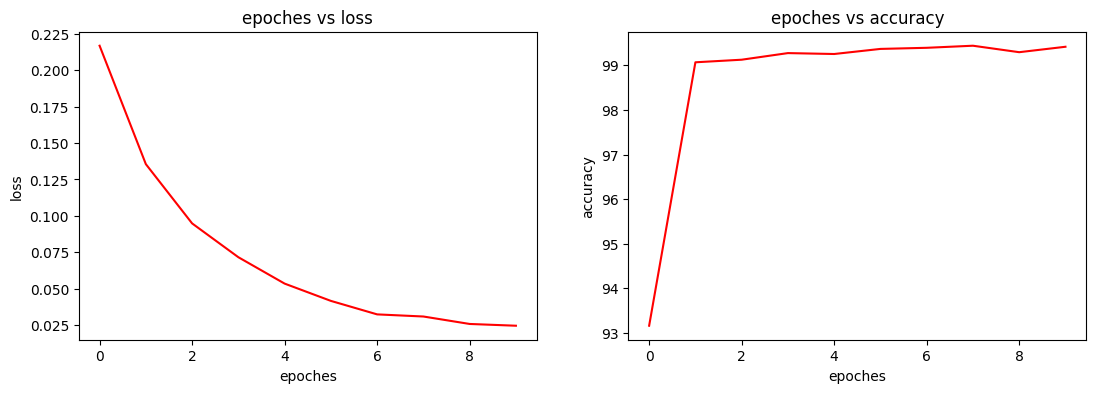

In [33]:
plt.figure(figsize=(13, 4))
plt.subplot(1,2,1)
plt.plot(loss,color="red")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.title("epoches vs loss")
plt.subplot(1,2,2)
plt.plot(accuracy,color="red")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.title("epoches vs accuracy")
plt.show()

In [34]:
test_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
data=Carvana(VALID_IMG_DIR,VALID_MASK_DIR,transforms=test_transform)


/tmp/ipykernel_36/2235180084.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, device=DEVICE).unsqueeze(0)


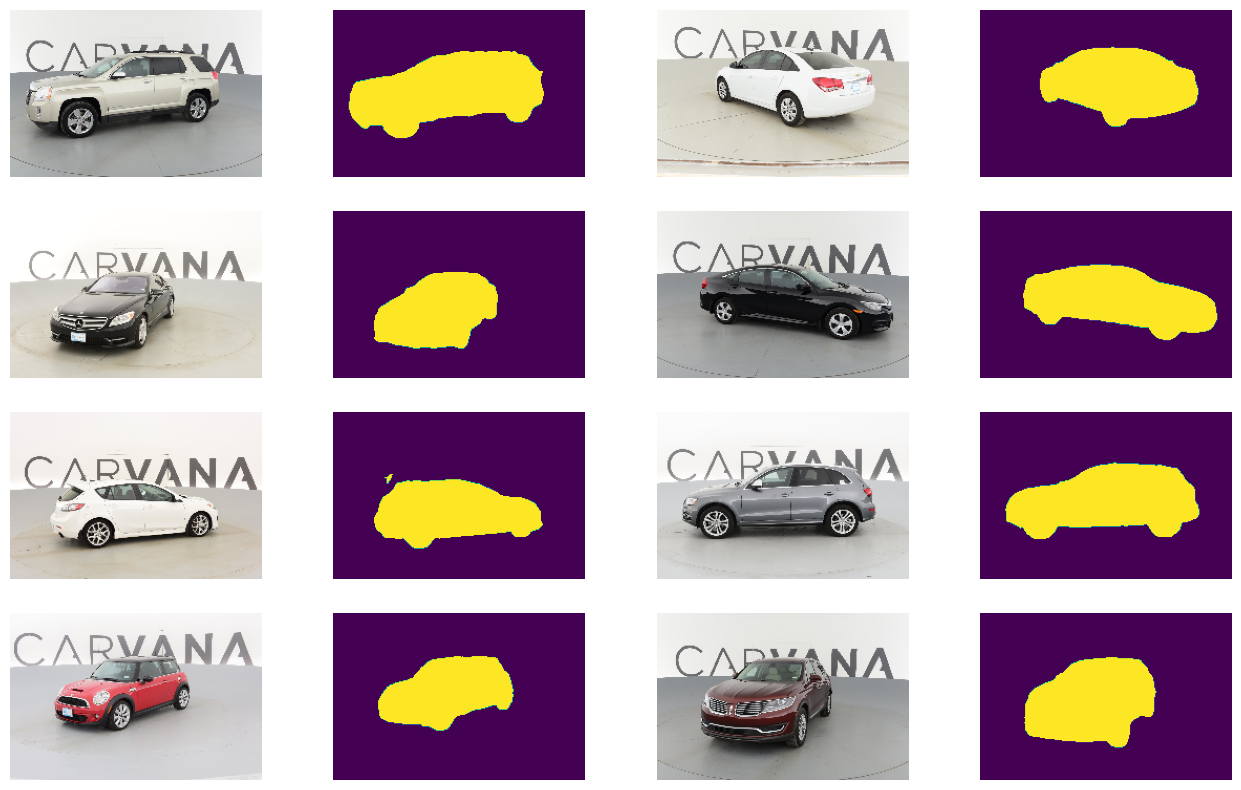

In [35]:
plt.figure(figsize=(16, 10))
model.eval()


for i in range(8):
    image, label = data[i]
    image_to_show = image

    
    image = torch.tensor(image, device=DEVICE).unsqueeze(0)

    with torch.no_grad():
        prd_mask = model(image.float())
        pred_mask = (torch.sigmoid(prd_mask) > 0.5).float().cpu()

    # Convert the tensor to a NumPy array
    mask = pred_mask[0].permute(1, 2, 0).numpy()

    # Plot original image and predicted mask side by side
    plt.subplot(4, 4, i * 2 + 1)
    plt.imshow(image_to_show.permute(1,2,0))
    plt.axis("off")

    plt.subplot(4, 4, i * 2 + 2)
    plt.imshow(mask)
    plt.axis("off")

plt.show()
# model.train()
